In [47]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, accuracy_score, average_precision_score, roc_auc_score

In [48]:
df = pd.read_csv('kaggle_data/playground-series-s3e17/train.csv')
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [49]:
df = df.drop(['id','Product ID'],axis=1)
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
136424,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


## 1 | EDA

### Data quality

#### 1. check duplicates

In [50]:
df_duplicated = df[df.duplicated()]
print(f'There are {df_duplicated.shape} duplicated rows')

There are (1156, 12) duplicated rows


In [51]:
df = df.drop_duplicates()
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


#### 2. check uniqueness

In [52]:
df.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [53]:
# check each column's uniqueness
for column in df.columns:
    uniqueness = len(df[column].unique())
    print(f"{column} : {uniqueness} distinct values")

Type : 3 distinct values
Air temperature [K] : 95 distinct values
Process temperature [K] : 81 distinct values
Rotational speed [rpm] : 952 distinct values
Torque [Nm] : 611 distinct values
Tool wear [min] : 246 distinct values
Machine failure : 2 distinct values
TWF : 2 distinct values
HDF : 2 distinct values
PWF : 2 distinct values
OSF : 2 distinct values
RNF : 2 distinct values


#### 3. check completeness

In [54]:
# check missing value
df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

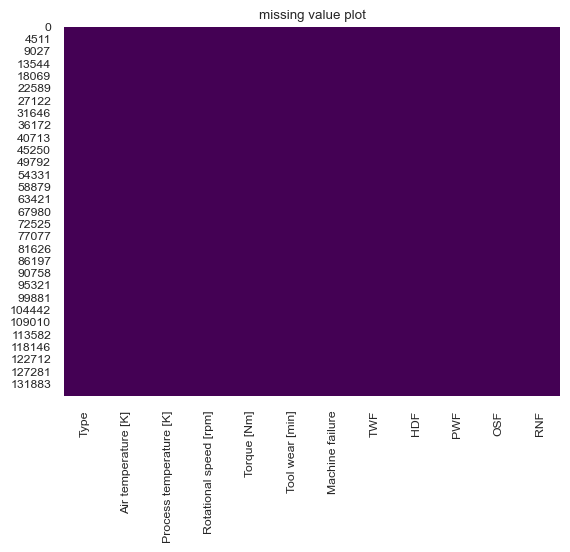

In [55]:
sns.heatmap(df.isnull(),cbar=False,cmap="viridis")
plt.title("missing value plot")
plt.show()

#### 4. Describe the data

In [56]:
df_numeric = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
df_categorical = df[['Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

In [57]:
statistic = df_numeric.describe().transpose()
statistic = statistic.drop('count',axis=1)
statistic

,mean,std,min,25%,50%,75%,max
Air temperature [K],299.863235,1.862659,295.3,298.3,300.0,301.2,304.4
Process temperature [K],309.941195,1.384932,305.8,308.8,310.0,310.9,313.8
Rotational speed [rpm],1520.343151,138.651099,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],40.341781,8.493127,3.8,34.6,40.4,46.1,76.6
Tool wear [min],104.358386,63.946150,0.0,48.0,106.0,159.0,253.0


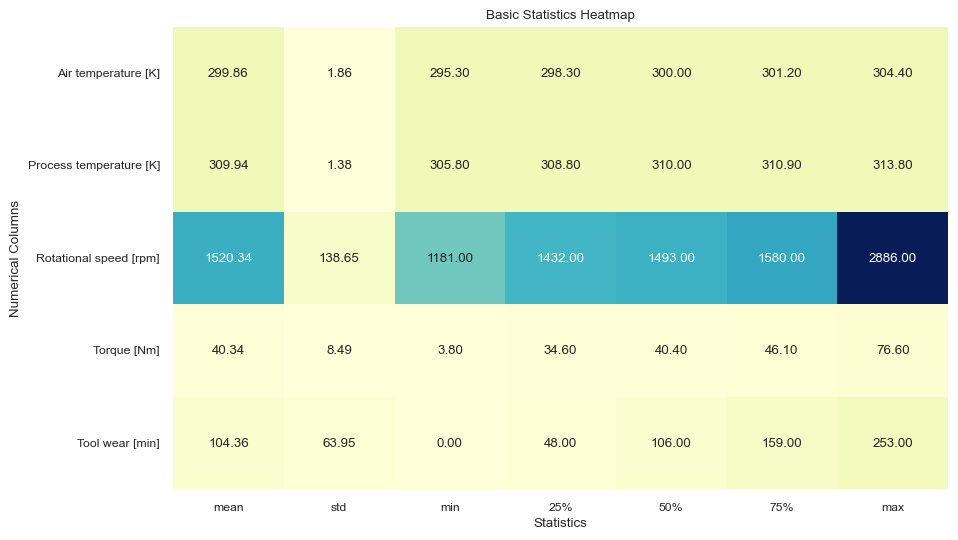

In [58]:
plt.figure(figsize=(10,6))
sns.heatmap(statistic,annot=True,cmap='YlGnBu',fmt='.2f',cbar=False)
plt.title("Basic Statistics Heatmap")
plt.xlabel("Statistics")
plt.ylabel("Numerical Columns")
plt.show()

### Univariate Analysis

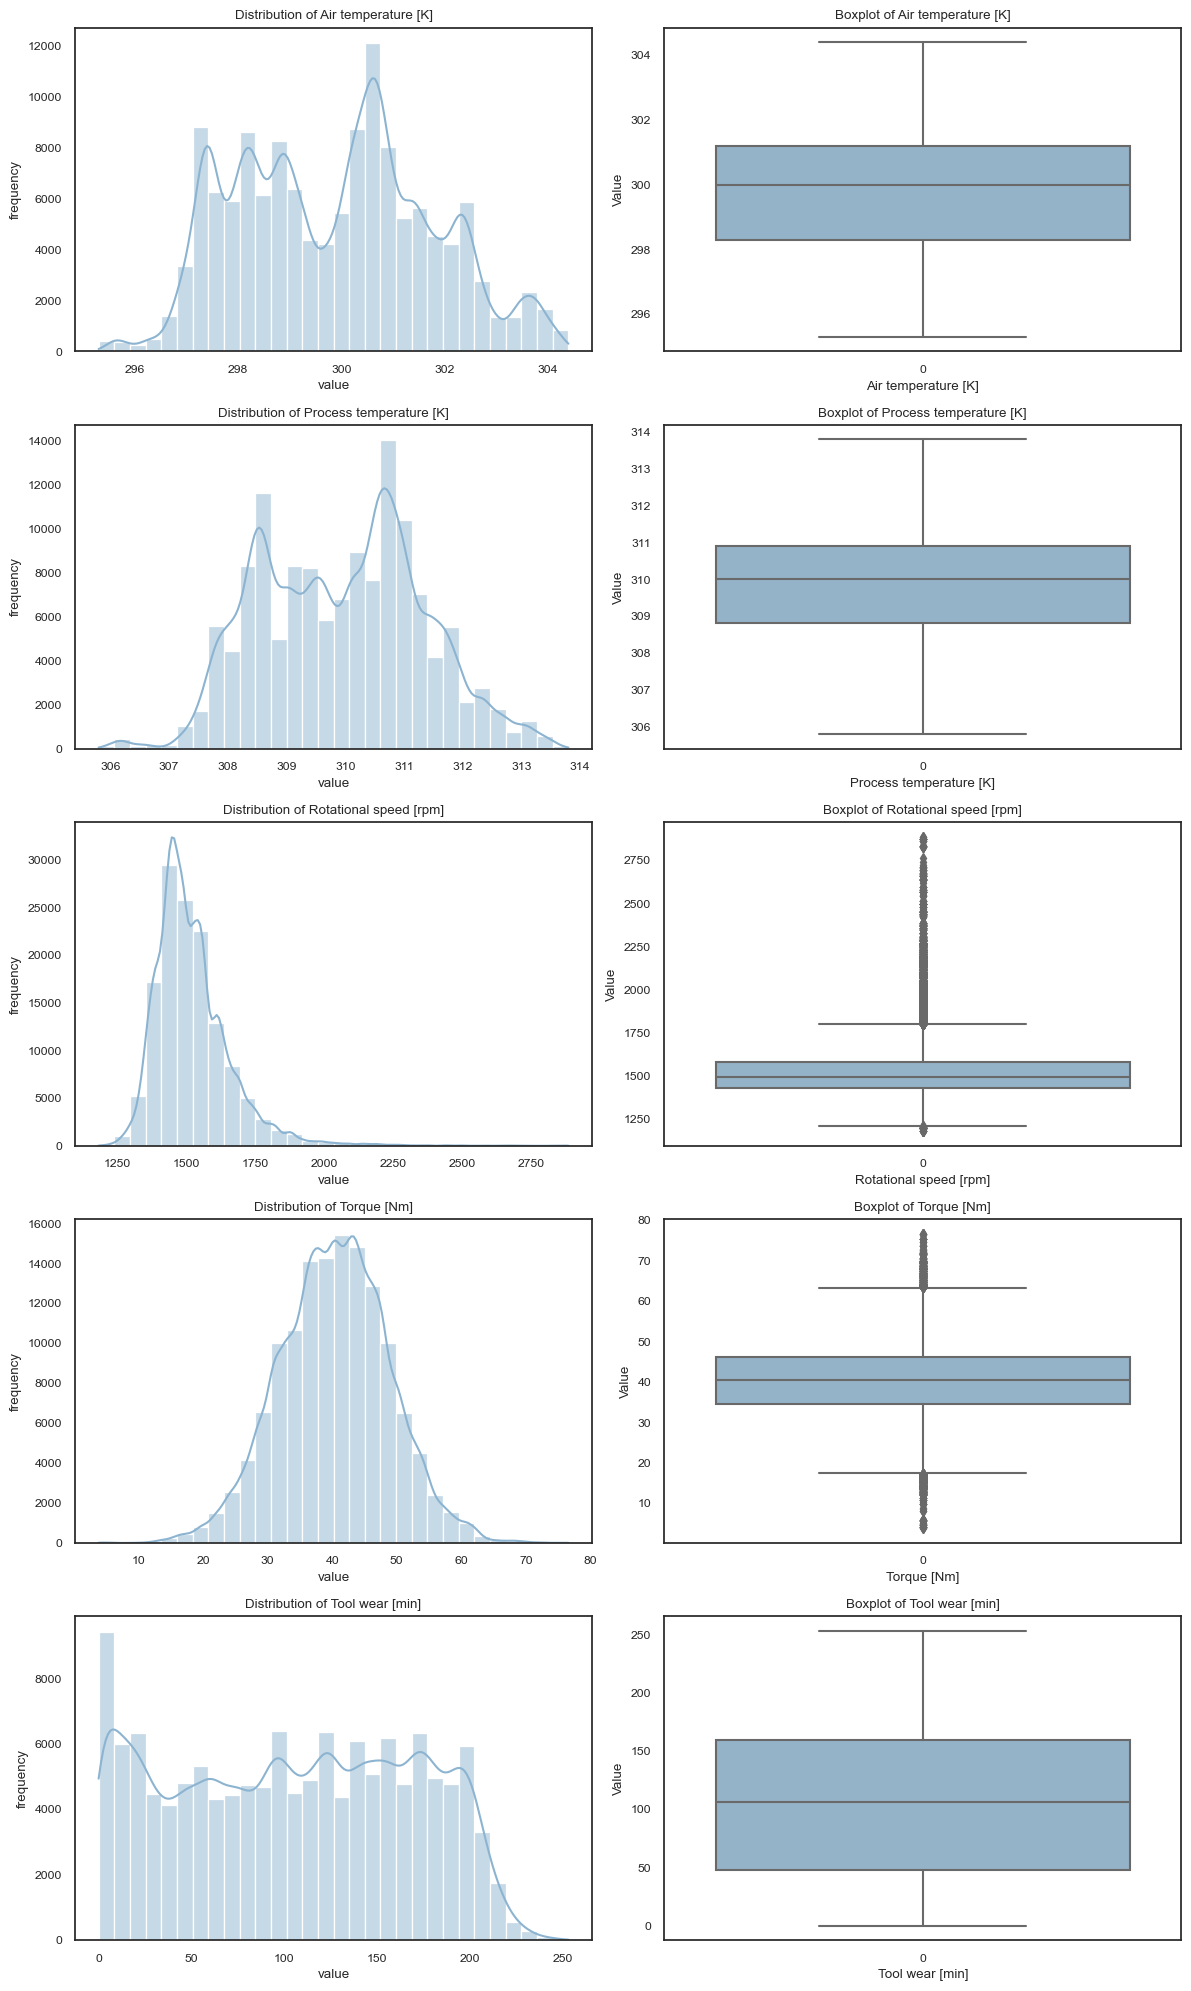

In [59]:
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12,20))
for idx, column in enumerate(numerical_columns):
    sns.histplot(df[column],bins=30,kde=True,ax=axes[idx,0])
    axes[idx,0].set_title(f'Distribution of {column}')
    axes[idx,0].set_xlabel('value')
    axes[idx,0].set_ylabel('frequency')
    sns.boxplot(df[column],ax=axes[idx,1])
    axes[idx,1].set_title(f'Boxplot of {column}')
    axes[idx,1].set_xlabel(column)
    axes[idx,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

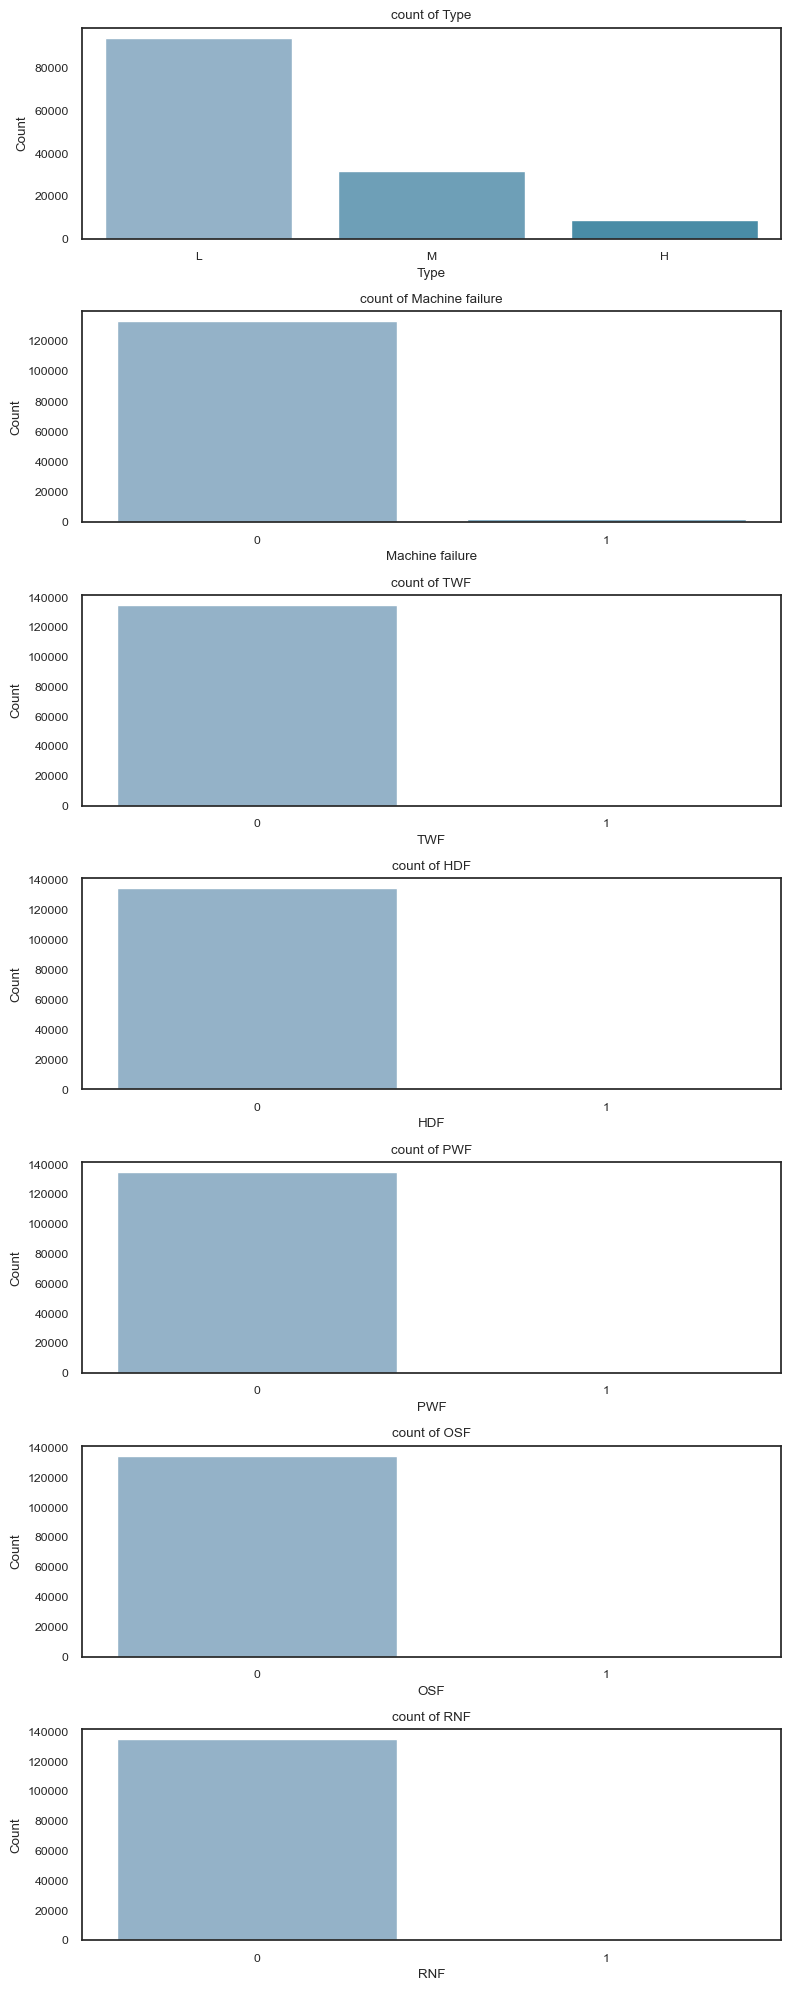

In [60]:
categorical_columns = ['Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(8, 20))
for idx, column in enumerate(categorical_columns):
    sns.countplot(x=df[column],ax=axes[idx])
    axes[idx].set_title(f"count of {column}")
    axes[idx].set_xlabel(f"{column}")
    axes[idx].set_ylabel(f"Count")

plt.tight_layout()
plt.show()


### Bivariate Analysis

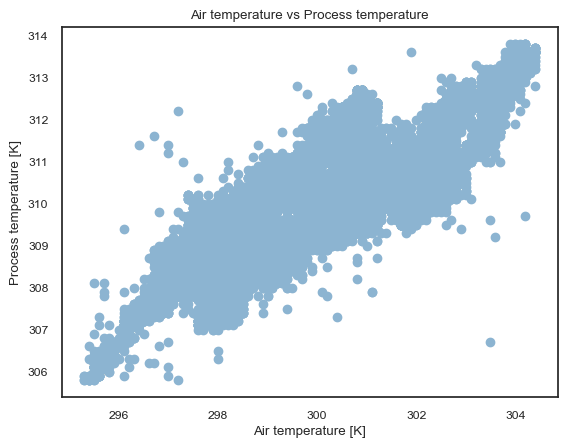

In [61]:
# Scatter Plot: Relationship between Air temperature and Process temperature.
plt.scatter(x=df['Air temperature [K]'], y=df['Process temperature [K]'])
plt.title('Air temperature vs Process temperature')
plt.xlabel('Air temperature [K]')
plt.ylabel('Process temperature [K]')
plt.show()


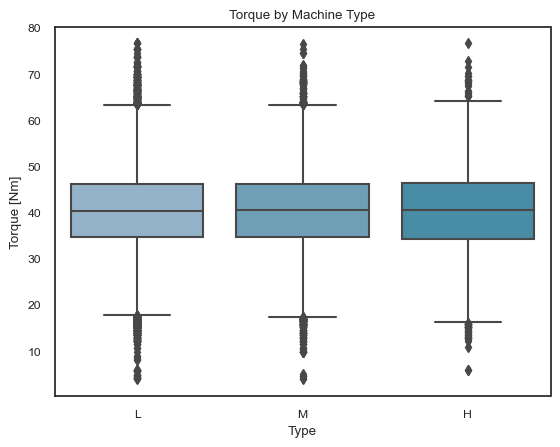

In [62]:
# Box Plot: Distribution of Torque for each type of machine.
sns.boxplot(x='Type',y='Torque [Nm]',data=df)
plt.xlabel('Type')
plt.ylabel('Torque [Nm]')
plt.title('Torque by Machine Type')
plt.show()

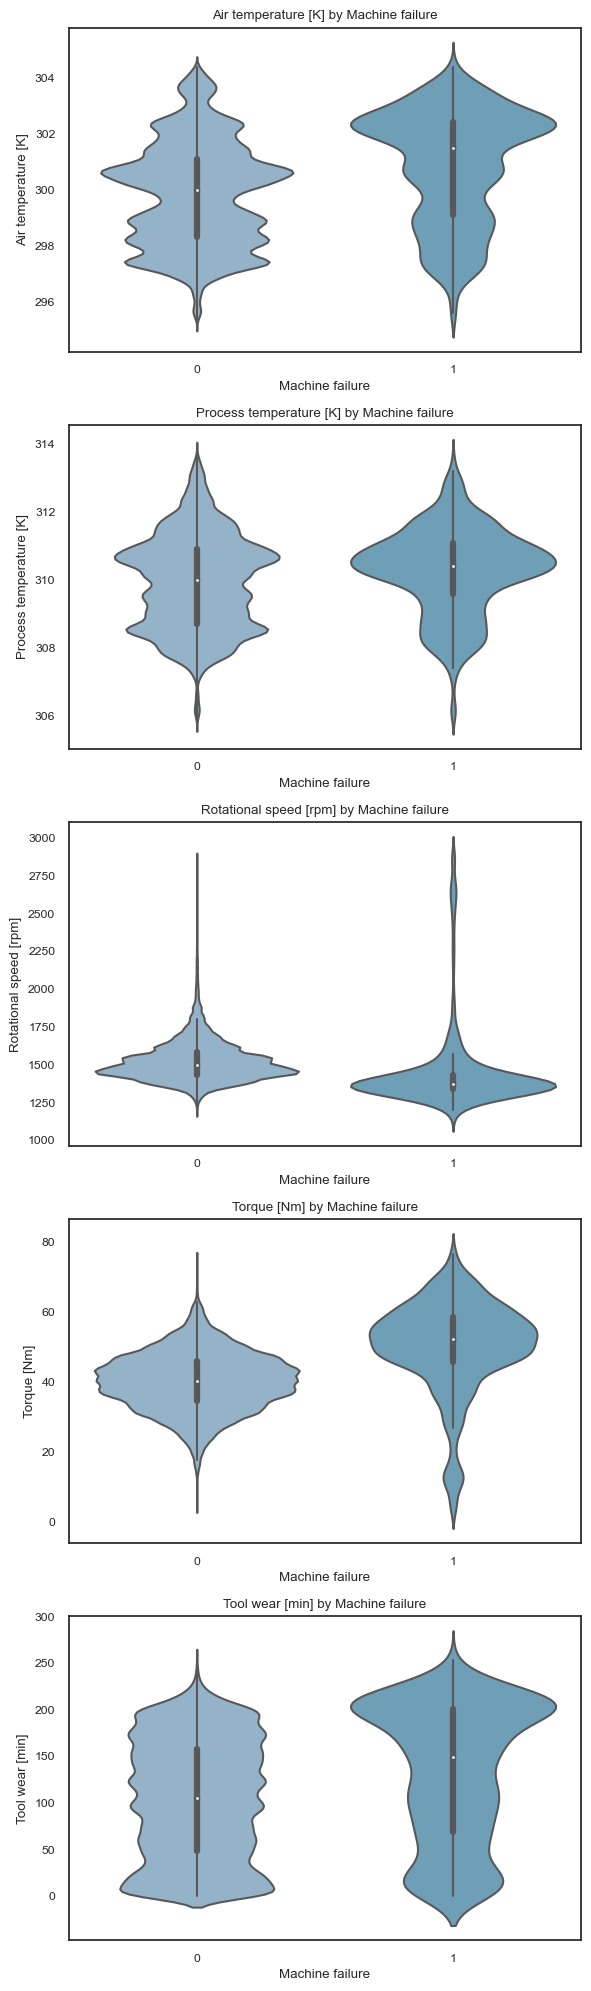

In [63]:
# Violin Plot: Distribution of Machine failure
numerical_vars = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(len(numerical_columns),1, figsize=(6,20))
for idx, column in enumerate(numerical_columns):
    sns.violinplot(x='Machine failure',y=column, data=df,ax=axes[idx])
    axes[idx].set_title(f"{column} by Machine failure")
    axes[idx].set_xlabel(f"Machine failure")
    axes[idx].set_ylabel(column)

plt.tight_layout()
plt.show()
    


🎻 Violin Plot Interpretation 🎻¶
The violin plots provide a comparison of the distributions of numeric variables for different machine failure states. The two categories represented are 'No Failure' and 'Failure'.

Air temperature [K] 🌡️

The distribution of air temperature for machines that have experienced failure tends to be higher compared to those that have not. This could suggest that higher air temperatures are associated with machine failure.

Process temperature [K] 🌡️

The distribution of process temperature for machines that have experienced failure is also higher. This could indicate that higher process temperatures are associated with machine failure.

Rotational speed [rpm] 🔄

The distribution of rotational speed for machines that have experienced failure appears to be lower. This could suggest that lower rotational speeds are associated with machine failure.

Torque [Nm] 💪

The distribution of torque for machines that have experienced failure is higher. This could suggest that higher torque is associated with machine failure.

Tool wear [min] ⏳

The distribution of tool wear for machines that have experienced failure is higher. This could suggest that longer tool usage is associated with machine failure.

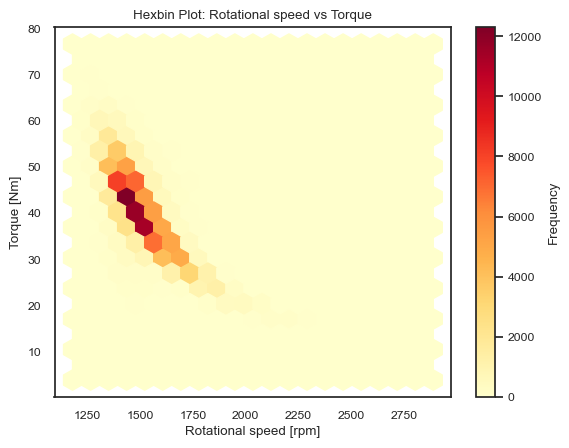

In [64]:
#Hexbin Plot: Relationship between Rotational speed and Torque.
plt.hexbin(df['Rotational speed [rpm]'], df['Torque [Nm]'], gridsize=20,cmap='YlOrRd')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('Hexbin Plot: Rotational speed vs Torque')
plt.colorbar(label='Frequency')
plt.show()

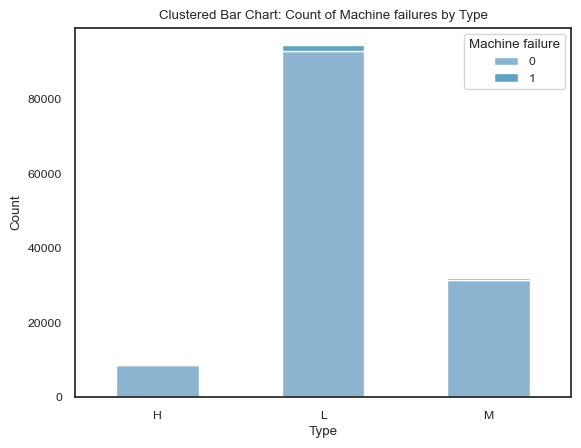

In [65]:
#Clustered Bar Chart: Count of Machine failures by Type.
df.groupby(['Type','Machine failure']).size().unstack().plot(kind='bar',stacked=True)
plt.xlabel('Type')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Clustered Bar Chart: Count of Machine failures by Type')
plt.show()

### 3. Multivariate Analysis

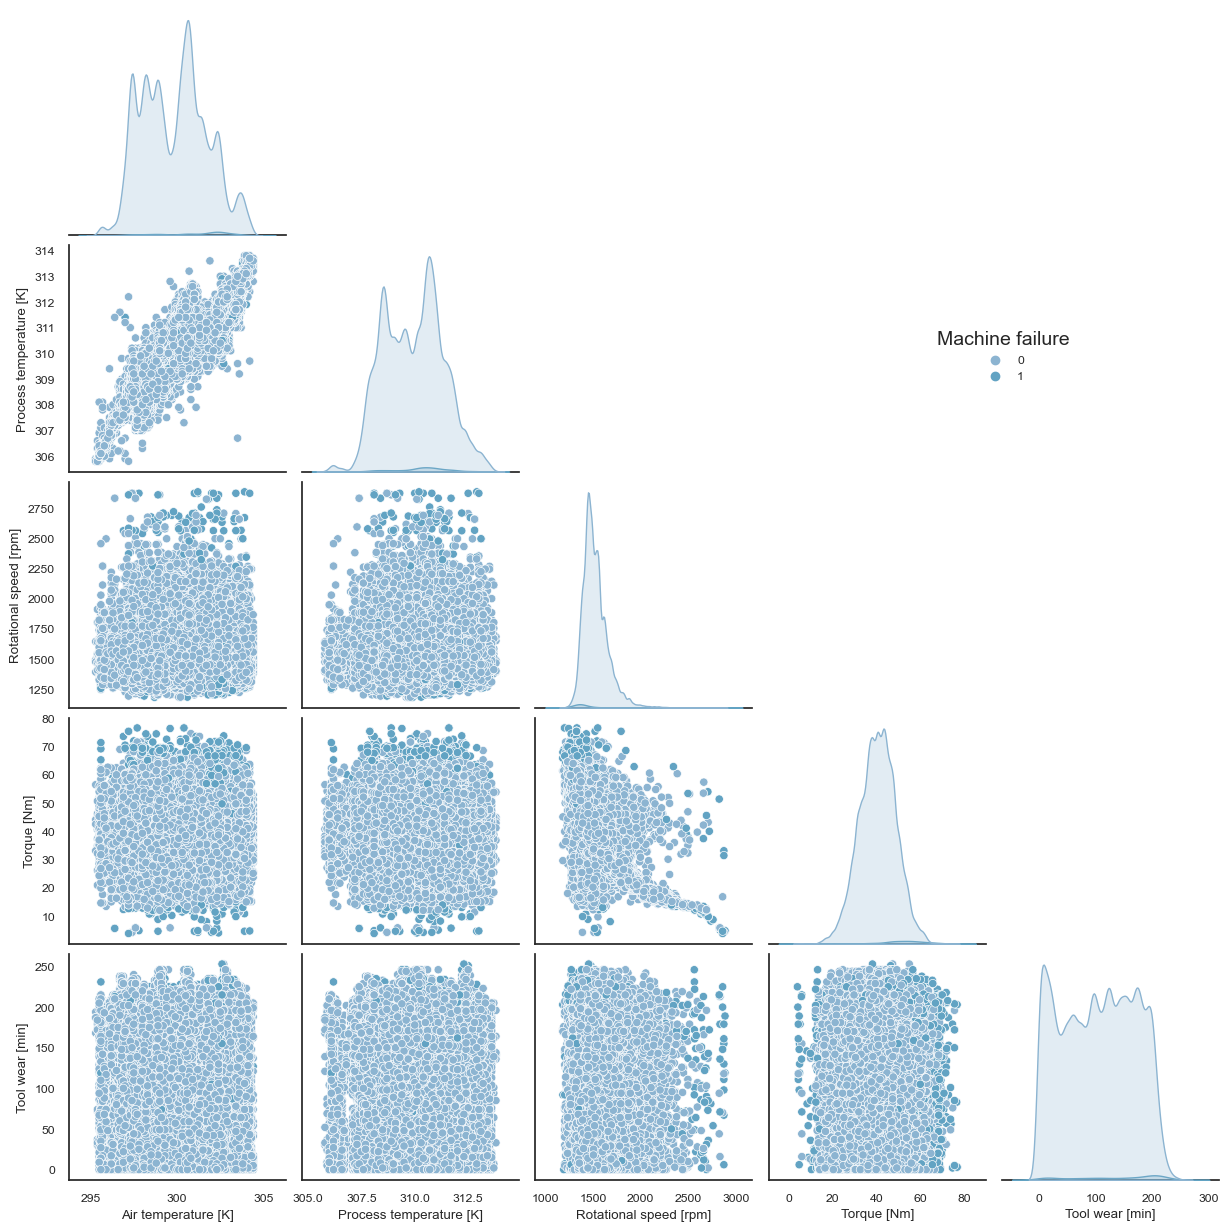

In [66]:
# Pair Plot: Scatter plot matrix of all numerical variables.
g = sns.pairplot(x_vars=numerical_vars,y_vars=numerical_vars,hue='Machine failure',data=df,corner=True)
g._legend.set_bbox_to_anchor((0.8, 0.7))
g._legend.set_title('Machine failure')
g._legend.loc = 'upper center'
g._legend.get_title().set_fontsize(14)
plt.show()

<Axes: xlabel='Type,TWF,HDF,PWF,OSF,RNF'>

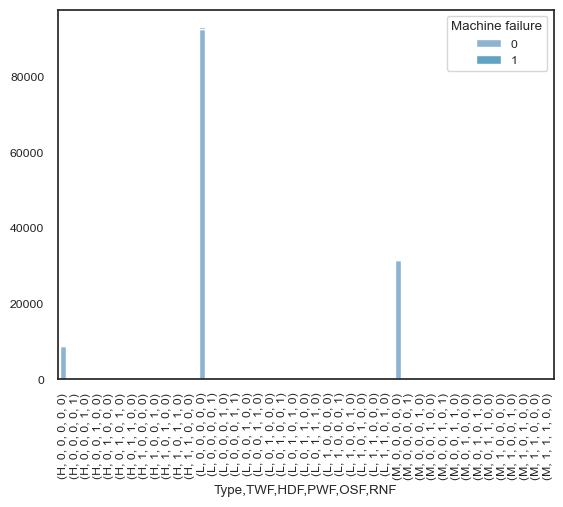

In [67]:
# Stacked Bar Chart: Count of Machine failures by Type, stacked by different failures.
df.groupby(['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Machine failure']).size().unstack().plot(kind='bar',stacked=True)


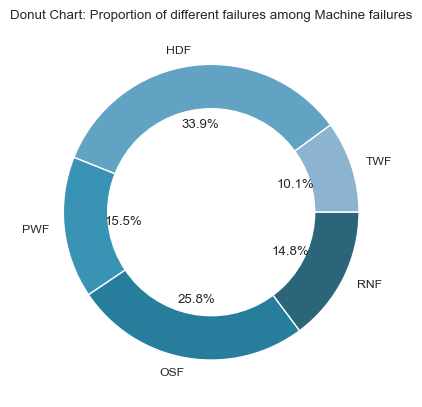

In [68]:
# Donut Chart: Proportion of different failures among Machine failures.
failure_counts = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()
plt.pie(failure_counts,labels=failure_counts.index,autopct='%1.1f%%')#,startangle=90)
circle = plt.Circle((0,0),0.7,color='white')
plt.gca().add_artist(circle)
plt.title('Donut Chart: Proportion of different failures among Machine failures')

plt.show()

🍩 Donut Chart Interpretation 🍩
The donut chart provides a comparison of the proportion of different types of failures among machine failures.

The types of failures compared are:

TWF (Tool Wear Failure) 🔧
HDF (Heat Dissipation Failure) 🔥
PWF (Power Failure) ⚡
OSF (Overstrain Failure) 💪
RNF (Random Failure) ❓
From the donut chart, we can observe the following:

TWF (Tool Wear Failure) 🔧

The proportion of tool wear failures among machine failures is represented by the corresponding segment in the donut chart. There are a total of 208 tool wear failures.

HDF (Heat Dissipation Failure) 🔥

The proportion of heat dissipation failures among machine failures is represented by the corresponding segment in the donut chart. There are a total of 701 heat dissipation failures.

PWF (Power Failure) ⚡

The proportion of power failures among machine failures is represented by the corresponding segment in the donut chart. There are a total of 320 power failures.

OSF (Overstrain Failure) 💪

The proportion of overstrain failures among machine failures is represented by the corresponding segment in the donut chart. There are a total of 533 overstrain failures.

RNF (Random Failure) ❓

The proportion of random failures among machine failures is represented by the corresponding segment in the donut chart. There are a total of 306 random failures.

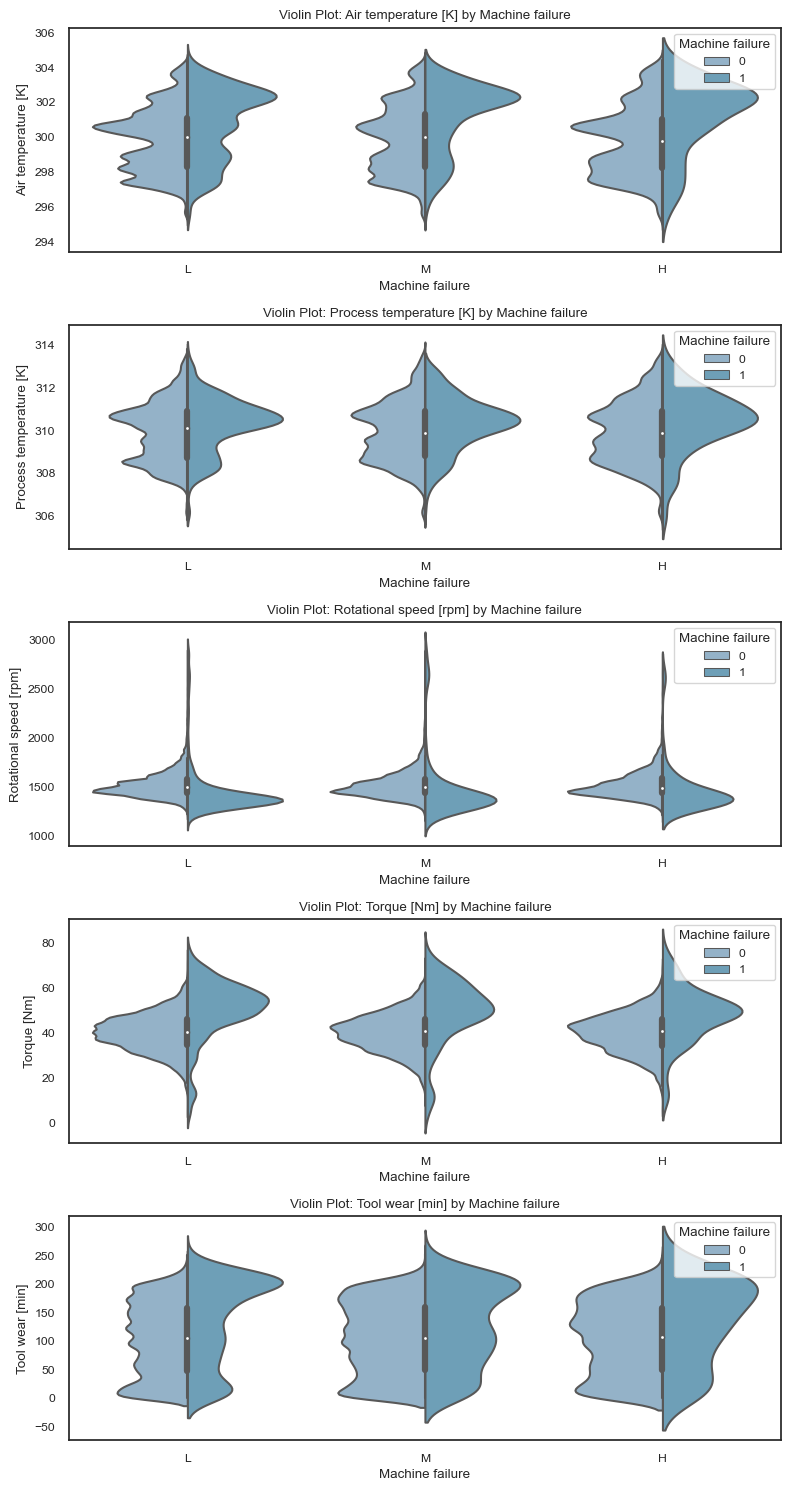

In [69]:
# Grouped Violin Plot: Distribution of Tool wear duration by Machine type, grouped by different failures.
numerical_vars = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
fig, axes = plt.subplots(len(numerical_vars),1,figsize=(8,15))
for idx,column in enumerate(numerical_vars):
    sns.violinplot(x='Type', y=column,hue='Machine failure',split=True,data=df,ax=axes[idx])
    axes[idx].set_xlabel('Machine failure')
    axes[idx].set_ylabel(column)
    axes[idx].set_title(f'Violin Plot: {column} by Machine failure')

plt.tight_layout()
plt.show()

🎻 Grouped Violin Plot Interpretation 🎻
The grouped violin plots provide a comparison of the distributions of numeric variables for different machine failure states, grouped by machine type. The two categories represented are 'No Failure' and 'Failure'.

Air temperature [K] 🌡️

The distribution of air temperature for machines that have experienced failure tends to be higher compared to those that have not. This pattern is observed across different machine types. This could suggest that higher air temperatures are associated with machine failure, regardless of the machine type.

Process temperature [K] 🌡️

The distribution of process temperature for machines that have experienced failure is also higher, across different machine types. This could indicate that higher process temperatures are associated with machine failure, regardless of the machine type.

Rotational speed [rpm] 🔄

The distribution of rotational speed for machines that have experienced failure appears to be lower, across different machine types. This could suggest that lower rotational speeds are associated with machine failure, regardless of the machine type.

Torque [Nm] 💪

The distribution of torque for machines that have experienced failure is higher, across different machine types. This could suggest that higher torque is associated with machine failure, regardless of the machine type.

Tool wear [min] ⏳

The distribution of tool wear for machines that have experienced failure is higher, across different machine types. This could suggest that longer tool usage is associated with machine failure, regardless of the machine type.

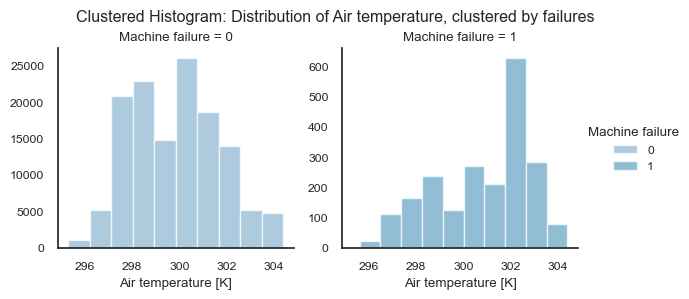

In [70]:
# Clustered Histogram: Distribution of Air temperature and Process temperature, clustered by different failures.
g = sns.FacetGrid(df, col='Machine failure',hue='Machine failure',sharey=False)
g.map(plt.hist,'Air temperature [K]',alpha=0.7)
g.add_legend()
g.fig.suptitle('Clustered Histogram: Distribution of Air temperature, clustered by failures')
plt.subplots_adjust(top=0.85)
plt.show()

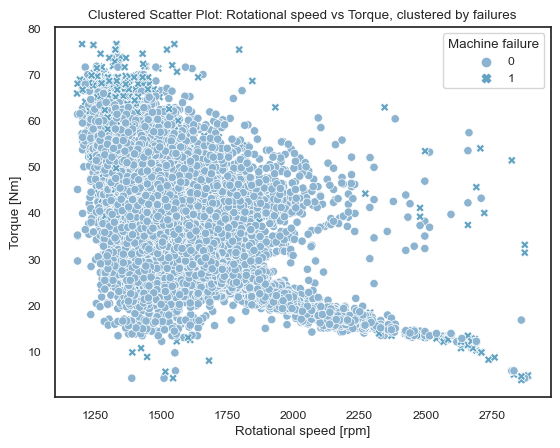

In [71]:
# Clustered Scatter Plot: Relationship between Rotational speed and Torque, clustered by different failures.
sns.scatterplot(x='Rotational speed [rpm]',y='Torque [Nm]',hue='Machine failure',style='Machine failure',data=df )
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.title('Clustered Scatter Plot: Rotational speed vs Torque, clustered by failures')
plt.show()


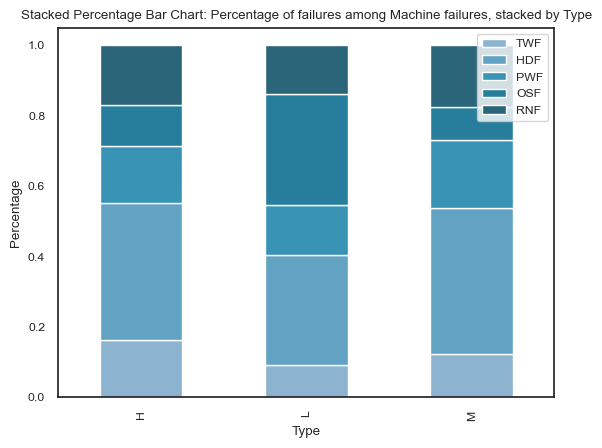

In [72]:
# Stacked Percentage Bar Chart: Percentage of different failures among Machine failures, stacked by Type.
failure_counts_by_type = df.groupby('Type')[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()
failure_counts_by_type.div(failure_counts_by_type.sum(axis=1),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.title('Stacked Percentage Bar Chart: Percentage of failures among Machine failures, stacked by Type')
plt.show()

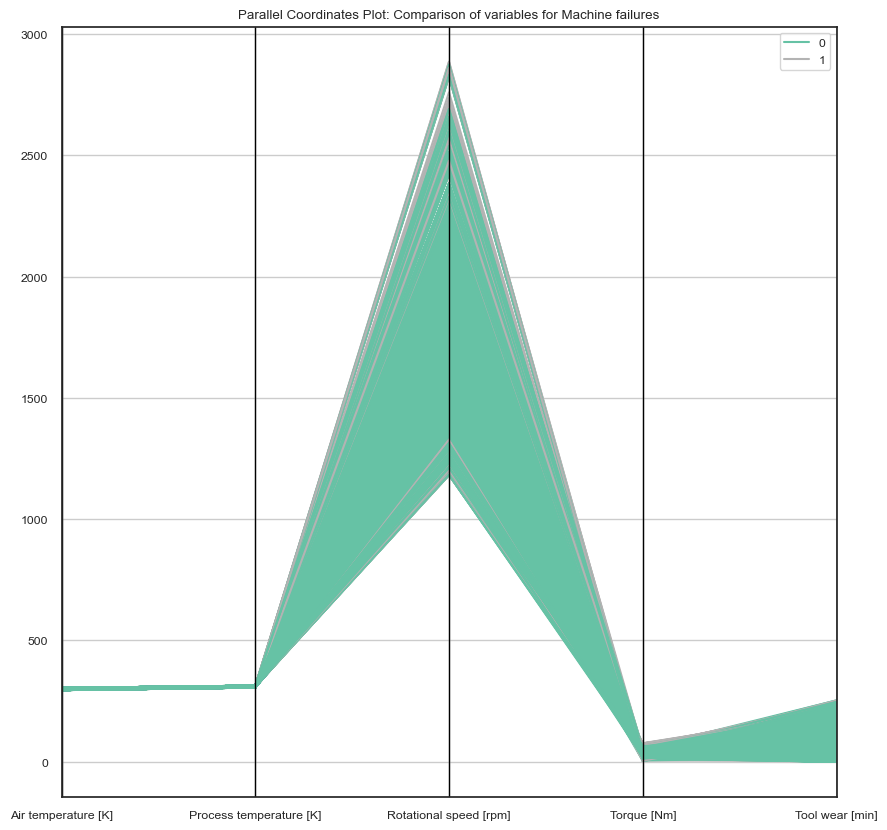

In [73]:
# Parallel Coordinates Plot: Comparison of numeric variables for different Machine failures.
plt.figure(figsize=(10,10))
parallel_coordinates(df[['Machine failure', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']], 'Machine failure', colormap='Set2')
plt.title('Parallel Coordinates Plot: Comparison of variables for Machine failures')
plt.show()

## 2 | CORRELATION MATRIX

#### 1. Adjust columns

In [74]:
categorical_columns = ['Type']
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','TWF', 'HDF', 'PWF', 'OSF', 'RNF','Machine failure']
dummy_variables = pd.get_dummies(df, columns=categorical_columns,drop_first=False)
dummy_variables

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,False,True,False
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,False,False,True
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,False,True,False
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,False,True,False
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,300.1,311.4,1530,37.5,210,0,0,0,0,0,0,False,False,True
136425,297.5,308.5,1447,49.1,2,0,0,0,0,0,0,True,False,False
136426,300.5,311.8,1524,38.5,214,0,0,0,0,0,0,False,True,False
136427,301.7,310.9,1447,46.3,42,0,0,0,0,0,0,False,True,False


#### 2.Preprocessing : Scaler

Preprocessing is a crucial step before training the model. In this case, numerical features are standardized (mean removed and scaled to unit variance), and categorical features are one-hot encoded. Standardization is not required for all models but is generally a good practice. One-hot encoding is necessary for categorical variables to be correctly understood by the machine learning model.​The StandardScaler in sklearn is based on the assumption that the data, Y, follows a distribution that might not necessarily be Gaussian (normal), but we still transform it in a way that its distribution will have a mean value 0 and standard deviation of 1.​

In other words, given a feature vector x, it modifies the values as follows:

​
𝑌𝑖=𝑥𝑖−𝜇(𝑥⃗ )𝜎(𝑥⃗ )
 
​where:
𝑥𝑖
  is the i-th element of the original feature vector  𝑥⃗ 
 ,
𝜇(𝑥⃗ )
  is the mean of the feature vector, and
𝜎(𝑥⃗ )
  is the standard deviation of the feature vector.
</ul>​
The transformed data  𝑌
  (each  𝑌𝑖
 ) will have properties such that  𝑚𝑒𝑎𝑛(𝑌)=0
  and  𝑠𝑡𝑑(𝑌)=1
 .

​
This transformation is also known as Z-score normalization.

In [75]:
scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(df[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical,columns=numerical_columns)
scaled_numerical_df

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,0.395546,-0.246363,0.545666,-0.499439,0.557371,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
1,1.469284,1.558786,1.721283,-1.323638,1.495664,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
2,-0.302383,-1.040629,2.053052,-1.629769,-1.241024,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
3,0.610294,0.692315,0.026375,0.466051,1.448750,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
4,-1.000313,-0.679599,0.870222,-0.581859,-1.100280,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
...,...,...,...,...,...,...,...,...,...,...,...
135268,0.127112,1.053344,0.069649,-0.334599,1.652046,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135269,-1.268747,-1.040629,-0.528978,1.031216,-1.600703,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135270,0.341860,1.342168,0.026375,-0.216856,1.714599,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135271,0.986102,0.692315,-0.528978,0.701537,-0.975174,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452


In [76]:
# Drop the original numerical columns
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenate the dummy variables and scaled numerical columns
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df

,Type_H,Type_L,Type_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,False,True,False,0.395546,-0.246363,0.545666,-0.499439,0.557371,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
1,False,False,True,1.469284,1.558786,1.721283,-1.323638,1.495664,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
2,False,True,False,-0.302383,-1.040629,2.053052,-1.629769,-1.241024,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
3,False,True,False,0.610294,0.692315,0.026375,0.466051,1.448750,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
4,False,False,True,-1.000313,-0.679599,0.870222,-0.581859,-1.100280,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134932,NaN,NaN,NaN,1.522971,0.403491,-0.290970,0.748634,-1.538150,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135127,NaN,NaN,NaN,-0.356070,0.620109,-0.428005,0.077500,-1.600703,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135149,NaN,NaN,NaN,0.449233,0.475697,1.944866,-1.453155,1.042156,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452
135170,NaN,NaN,NaN,-0.033949,0.620109,-0.420793,0.324760,0.885774,-0.039243,-0.072174,-0.048695,-0.062895,-0.047615,-0.126452


#### 3.Correlation Matrix

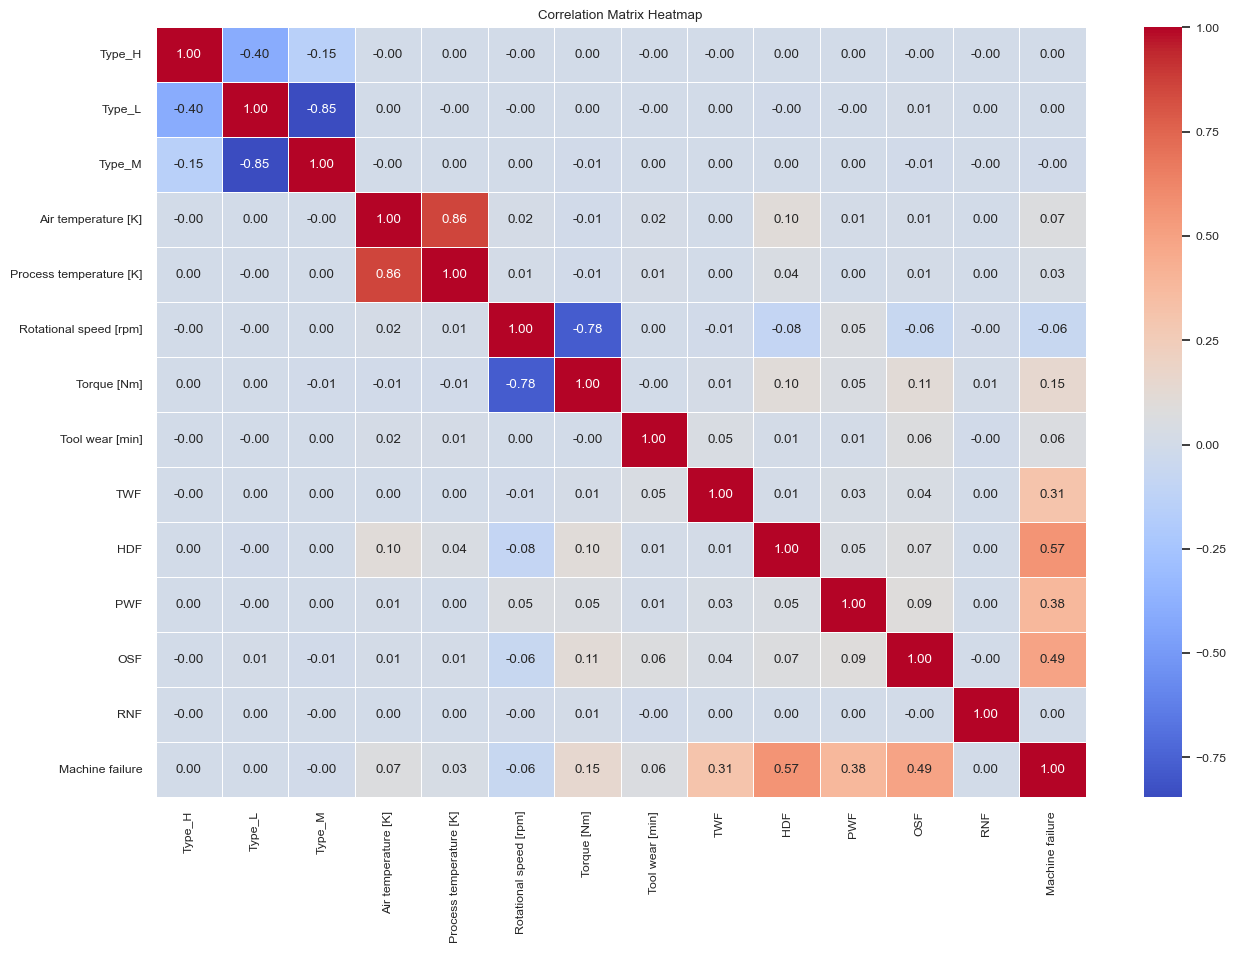

In [77]:
# Graph I.
correlation_matrix = processed_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(data=correlation_matrix,annot=True,cmap='coolwarm', linewidths=0.5,fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


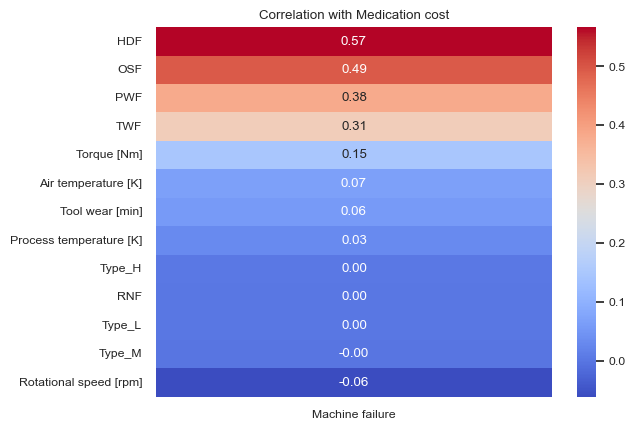

In [78]:
# Graph II

corr = processed_df.corr()
target_corr = corr['Machine failure'].drop('Machine failure')
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(data=target_corr_sorted.to_frame(),annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation with Medication cost')
plt.show()


Intepret the results 📊
Our analysis of the machine failure dataset revealed several interesting patterns and relationships. The dataset included various features such as air temperature, process temperature, rotational speed, torque, and tool wear time, along with different types of machine failures.

Observations

HDF (Heat Dissipation Failure) 🔥: There is a strong positive correlation between heat dissipation failure and machine failure. This suggests that machines with heat dissipation failure are more likely to fail.

OSF (Overstrain Failure) 💪: There is a positive correlation between overstrain failure and machine failure. This suggests that machines with overstrain failure are more likely to fail.

PWF (Power Failure) ⚡: There is a positive correlation between power failure and machine failure. This suggests that machines with power failure are more likely to fail.

TWF (Tool Wear Failure) 🔧: There is a positive correlation between tool wear failure and machine failure. This suggests that machines with tool wear failure are more likely to fail.

Torque [Nm] 💪: There is a positive correlation between torque and machine failure. This suggests that machines with higher torque are more likely to fail.

Air temperature [K] 🌡️: There is a slight positive correlation between air temperature and machine failure. This suggests that machines with higher air temperatures are slightly more likely to fail.

Tool wear [min] ⏳: There is a slight positive correlation between tool wear time and machine failure. This suggests that machines with longer tool usage are slightly more likely to fail.

Process temperature [K] 🌡️: There is a slight positive correlation between process temperature and machine failure. This suggests that machines with higher process temperatures are slightly more likely to fail.

Type_L 🅾️: There is a slight positive correlation between machines of type L and machine failure. This suggests that machines of type L are slightly more likely to fail.

RNF (Random Failure) ❓: There is a very slight positive correlation between random failure and machine failure. This suggests that machines with random failure are slightly more likely to fail.

`Type_H** 🅾️: There is a slight negative correlation between machines of type H and machine failure. This suggests that machines of type H are slightly less likely to fail.

Type_M 🅾️: There is a slight negative correlation between machines of type M and machine failure. This suggests that machines of type M are slightly

## 3 | CLUSTERING ANALYSIS

In [79]:
def preprocess_data(df):
    le = LabelEncoder()
    df['Type'] = le.fit_transform(df['Type'])

    scaler = StandardScaler()
    numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    return df

def determine_optimal_clusters(df):
    wcss = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1,11),wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()    

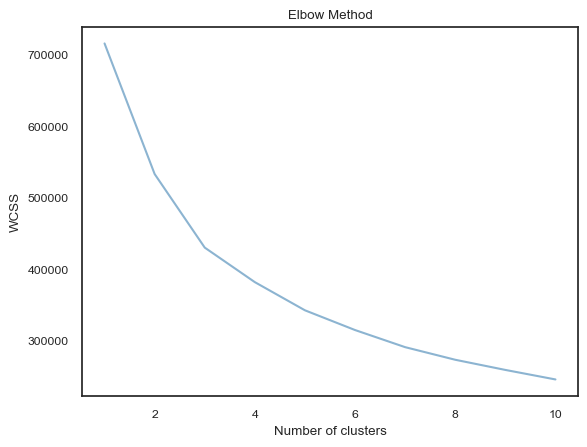

In [80]:
df_cluster = preprocess_data(df)
df_X = df.drop('Machine failure',axis=1)
determine_optimal_clusters(df_X)

📊 Elbow Method Plot Interpretation 📊¶
The Elbow Method plot is a technique used to help us find the optimal number of clusters for a dataset in K-Means clustering or any clustering algorithm.

From the Elbow Method plot, we can observe the following:

WSS (Within-Cluster Sum of Squares) 📈: The y-axis represents the WSS, which is the sum of the squared distance between each member of the cluster and its centroid. As the number of clusters increases, the WSS value will start to decrease.

Number of Clusters 🧮: The x-axis represents the number of clusters.

The "elbow" in the plot is the point of inflection where the rate of decrease sharply shifts. This is typically considered as the appropriate number of clusters.

Observation

From the plot, it appears that the elbow point is around 4 clusters. This suggests that the optimal number of clusters for the data is around 4.

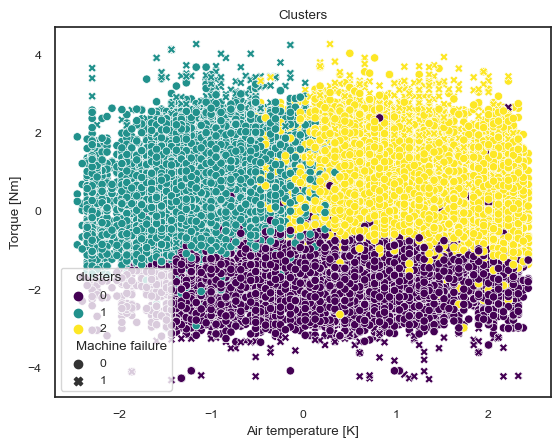

In [81]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10,random_state=0)
clusters = kmeans.fit_predict(df_X)

df['clusters'] = clusters

sns.scatterplot(x='Air temperature [K]',y='Torque [Nm]',hue='clusters',style='Machine failure',palette='viridis',data=df)
plt.title('Clusters')
plt.xlabel('Air temperature [K]')
plt.ylabel('Torque [Nm]')
plt.show()


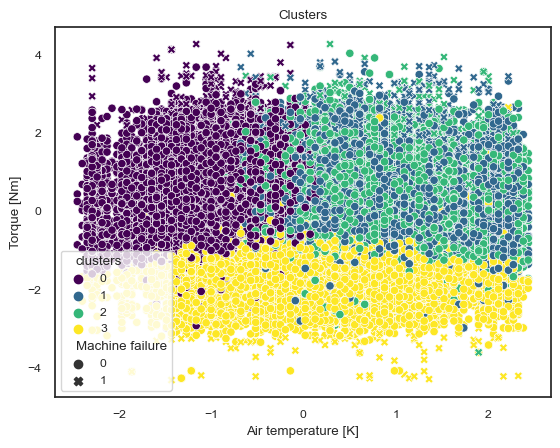

In [82]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10,random_state=0)
clusters = kmeans.fit_predict(df_X)

df['clusters'] = clusters

sns.scatterplot(x='Air temperature [K]',y='Torque [Nm]',hue='clusters',style='Machine failure',palette='viridis',data=df)
plt.title('Clusters')
plt.xlabel('Air temperature [K]')
plt.ylabel('Torque [Nm]')
plt.show()


📊 Scatter Plot Interpretation 📊
The scatter plot is used to visualize the clusters formed by the K-Means clustering algorithm based on the features Air temperature [K] and Torque [Nm].

From the scatter plot, we can observe the following:

Air temperature [K] 🌡️: The x-axis represents the air temperature in Kelvin.

Torque [Nm] 💪: The y-axis represents the torque in Newton meters.

Clusters 🧩: Different clusters are represented by different colors.

Machine failure ❌: The machine failure is represented by different markers.

Observation

From the plot, it appears that the K-Means clustering algorithm has divided the data into four distinct clusters. Each cluster represents a group of machines with similar air temperatures and torque values. The machines that experienced failure (represented by different markers) are scattered across all clusters.

## 4 | Adaboost

In [83]:
df = pd.read_csv('kaggle_data/playground-series-s3e17/train.csv')
df = df.drop(['id', 'Product ID'], axis=1)
df= df.drop_duplicates()
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
136424,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


#### Preprocessing data

In [85]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [86]:
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Hyperparameter Tuning

In [87]:
param_grid = {'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]}
grid = GridSearchCV(AdaBoostClassifier(),param_grid=param_grid, refit=True,verbose=1)
grid.fit(X_train,y_train)
print(grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'learning_rate': 0.3, 'n_estimators': 200}


🧠 Understanding the Parameters¶
The `Learning Rate` of 0.3 is the pace at which our model learns. A higher learning rate allows the model to learn faster, but it's a delicate balance. Too fast, and the model might not perform as well.

The `Number of Estimators` is set at 200. This is the count of weak learners that the model trains iteratively. More learners can lead to better learning, but we must be cautious. Too many can increase the risk of overfitting and the computational cost.

In [88]:
best_learning_rate = 0.3
best_estimator = 200

ada = AdaBoostClassifier(learning_rate=best_learning_rate,n_estimators=best_estimator)
ada.fit(X_train,y_train)

scores = cross_val_score(ada, X,y,cv=10)
print(f'Cross validation score: {scores}')

average_cv_score = np.mean(scores)
print(f"Average cross validation score: {average_cv_score}")

y_pred = ada.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, y_pred)}")


Cross validation score: [0.99623004 0.99600828 0.99578652 0.99674725 0.99667332 0.99637762
 0.99608191 0.99630369 0.99630369 0.9951948 ]
Average cross validation score: 0.9961707102473765
Model accuracy: 0.9966364812419146


📈 Model Performance Metrics
After training and evaluating our AdaBoost model, we have obtained the following key performance metrics:

`Average Cross-Validation Score`: 0.996
`Model Accuracy`: 0.996
🧠 Understanding the Metrics
The scores above represent the accuracy of our AdaBoost model on each of the 10 folds used in the cross-validation process. These scores give us a good idea of how well our model is performing across different subsets of our data.

The `Average Cross-Validation Score` is the mean of the accuracy scores of our AdaBoost model for each of the folds used in the cross-validation process. It gives us a good idea of how well our model is expected to perform on unseen data.

The `Model Accuracy` is the proportion of correct predictions made by our model on the test set. It tells us how well our model performed when it was exposed to previously unseen data.

#### Classification Report

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26621
           1       1.00      0.79      0.88       434

    accuracy                           1.00     27055
   macro avg       1.00      0.90      0.94     27055
weighted avg       1.00      1.00      1.00     27055



🧠 Understanding the Report¶
`Precision` for class 0 is 1.00, which means that all instances that our model predicted as class 0 (no failure) were indeed class 0. For class 1 (failure), the precision is also 1.00, meaning that all instances that our model predicted as class 1 were indeed class 1. This indicates that our model is very reliable when it predicts a class.

`Recall` for class 0 is 1.00, which means that our model detected all instances of class 0. However, for class 1, the recall is 0.79, which means that our model detected 79% of the instances of class 1. This suggests that our model is somewhat less effective at detecting failures (class 1) compared to non-failures (class 0).

The `F1-score` for class 0 is 1.00, indicating a perfect balance between precision and recall for this class. For class 1, the F1-score is 0.88, which is lower due to the lower recall for this class.

`Support` shows that we have a highly imbalanced dataset, with 26,621 instances of class 0 and only 434 instances of class 1. This imbalance might be affecting our model's performance, particularly for class 1.

The `accuracy` of 1.00 indicates that our model made correct predictions for the vast majority of instances. However, given the imbalance in our dataset, accuracy might not be the best metric to evaluate our model's performance.

The `macro avg` and `weighted avg` provide us with average measures of our model's performance, taking into account both classes. The macro average treats both classes equally, while the weighted average takes into account the imbalance in our dataset.

#### Confusion Matrix

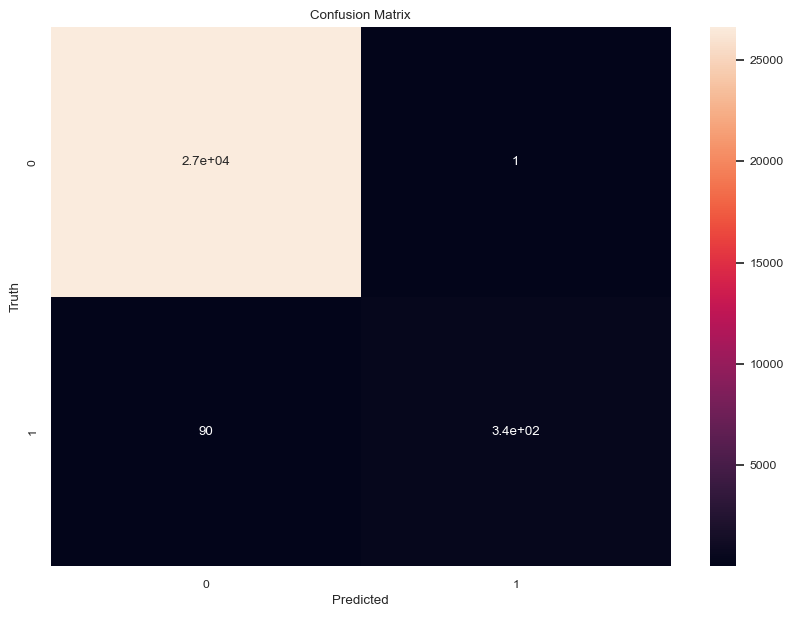

In [90]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

🧠 Understanding the Matrix¶
The confusion matrix gives us a more detailed breakdown of our model's performance:

`True Positives (TP)`: These are cases in which we predicted failure (1), and the actual outcome was also failure. We have 344 TP.

`True Negatives (TN)`: We predicted no failure (0), and the actual outcome was no failure. We have 26,620 TN.

`False Positives (FP)`: We predicted failure, but the actual outcome was no failure. Also known as "Type I error". We have 1 FP.

`False Negatives (FN)`: We predicted no failure, but the actual outcome was failure. Also known as "Type II error". We have 90 FN.

#### ROC Curve and AUC Score

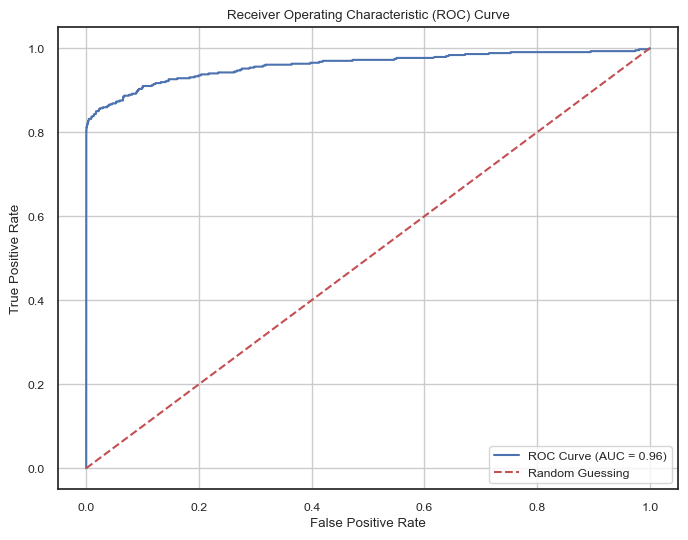

In [91]:
probabilities = ada.predict_proba(X_test)

prob_class_1 = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_class_1)
auc_score = roc_auc_score(y_test, prob_class_1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score), color='b')
plt.plot([0, 1], [0, 1], 'k--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

📈 ROC Curve and AUC Score
The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of our AdaBoost model at all classification thresholds. The Area Under the Curve (AUC) score represents the model's ability to distinguish between positive and negative classes.

And our AUC Score is: 0.96

🧠 Understanding the ROC Curve and AUC Score
The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The AUC score, ranging from 0 to 1, tells us how much our model is capable of distinguishing between classes. The higher the AUC, the better our model is at predicting 0s as 0s and 1s as 1s. An AUC score of 0.5 denotes a bad class separation capacity equivalent to random guessing, while an AUC score of 1 denotes an excellent class separation capacity.

The Area Under the Curve (AUC) score is a single number summary of the ROC curve. An AUC score of 1 indicates a perfect model; 0.5 suggests a worthless model. Our model has an AUC score of 0.96, indicating a high level of prediction accuracy.

#### Precision-Recall Curve and Average Precision

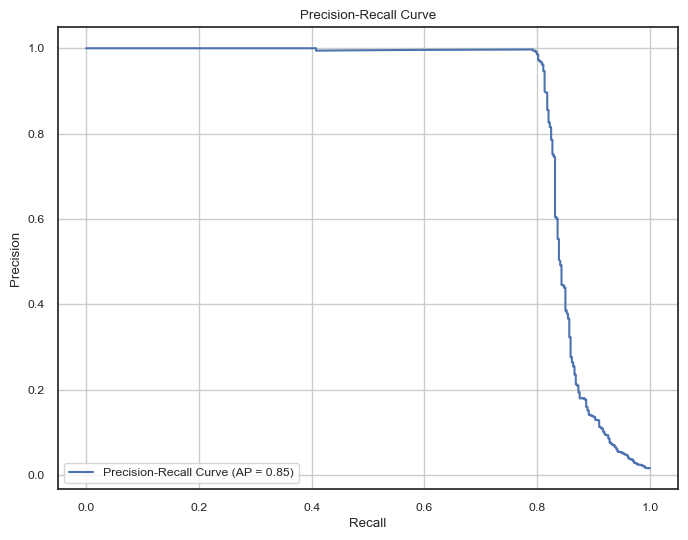

In [92]:
probabilities = ada.predict_proba(X_test)
prob_class_1 = probabilities[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, prob_class_1)
average_precision = average_precision_score(y_test, prob_class_1)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (AP = {:.2f})'.format(average_precision), color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

🧠 Understanding the Precision-Recall Curve and Average Precision¶
The Precision-Recall curve shows the trade-off between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

The Average Precision provides a single number that summarizes the information in the Precision-Recall curve. It is calculated as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

## 5 | XGBoost

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

In [94]:
df = pd.read_csv('kaggle_data/playground-series-s3e17/train.csv')
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [95]:
df = df.drop(['id', 'Product ID'], axis=1)
df = df.drop_duplicates()
X = df.drop('Machine failure',axis=1)
X.columns = [i.replace('[','').replace(']','').replace(' ','_') for i in X.columns]
y = df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
param_grid = {'n_estimators':np.linspace(100,2000,20,dtype=int), 
              'learning_rate':np.linspace(0.01,0.1,10),
              'max_depth':[3,5,7],
              'subsample':np.linspace(0.1,1,20),
              'colsample_bytree': np.linspace(0.1, 1.0, 20),
              'eval_metric':['auc']
              }

In [97]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

In [98]:
random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=param_grid,
                                   n_iter=20,
                                #    scoring='accuracy',
                                   cv=5,
                                   random_state=42)


In [99]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]),
                                        'subsample': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ])},
                   random_state=42)

In [100]:
best_params = random_search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'subsample': 0.38421052631578945, 'n_estimators': 1400, 'max_depth': 3, 'learning_rate': 0.01, 'eval_metric': 'auc', 'colsample_bytree': 0.7631578947368421}


In [101]:
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7631578947368421, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [102]:
feature_importance = best_xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

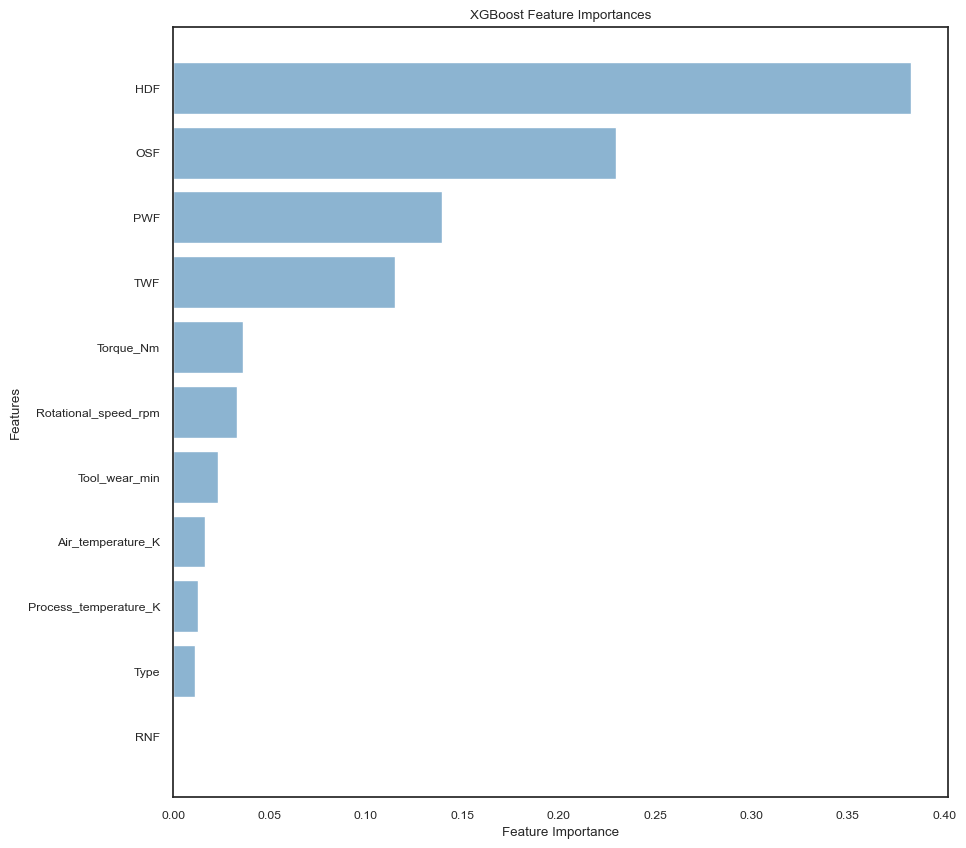

In [103]:
feature_pair = list(zip(X.columns, feature_importance))
sorted_feature_pair = [feature_pair[i] for i in sorted_idx]
plt.figure(figsize=(10,10))
plt.barh(y=np.arange(len(sorted_feature_pair)),width=[i[1] for i in sorted_feature_pair],tick_label=[i[0] for i in sorted_feature_pair])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importances')
plt.show()

In [104]:
y_pred = best_xgb_model.predict(X_test)


In [105]:
scores = cross_val_score(best_xgb_model, X,y,cv=10)
print(f'Cross validation score: {scores}')

average_cv_score = np.mean(scores)
print(f"Average cross validation score: {average_cv_score}")

y_pred = best_xgb_model.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, y_pred)}")

Cross validation score: [0.99630396 0.99600828 0.9957126  0.99674725 0.99659939 0.99637762
 0.99615584 0.99630369 0.99630369 0.99534265]
Average cross validation score: 0.9961854954917027
Model accuracy: 0.996673442986509


In [106]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26621
           1       0.99      0.80      0.88       434

    accuracy                           1.00     27055
   macro avg       1.00      0.90      0.94     27055
weighted avg       1.00      1.00      1.00     27055



#### Confusion Matrix

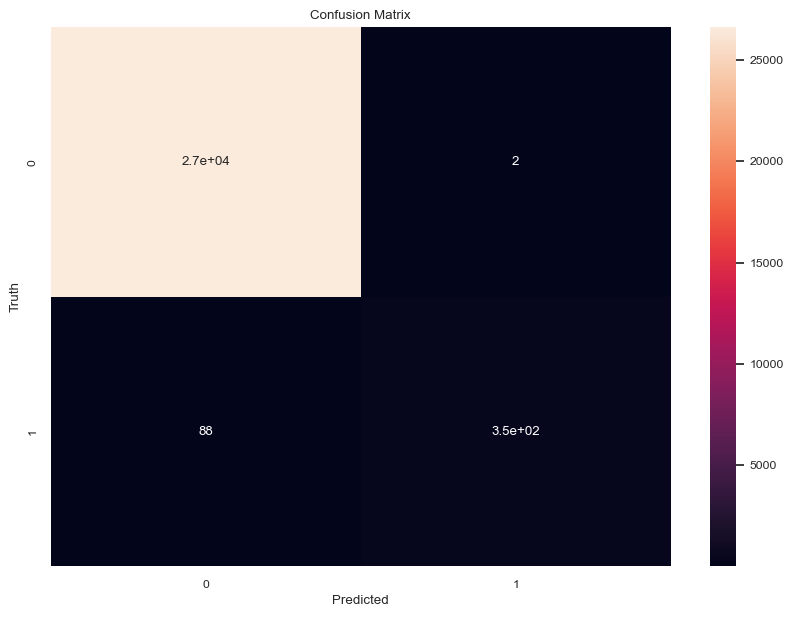

In [107]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

#### ROC Curve and AUC Curve

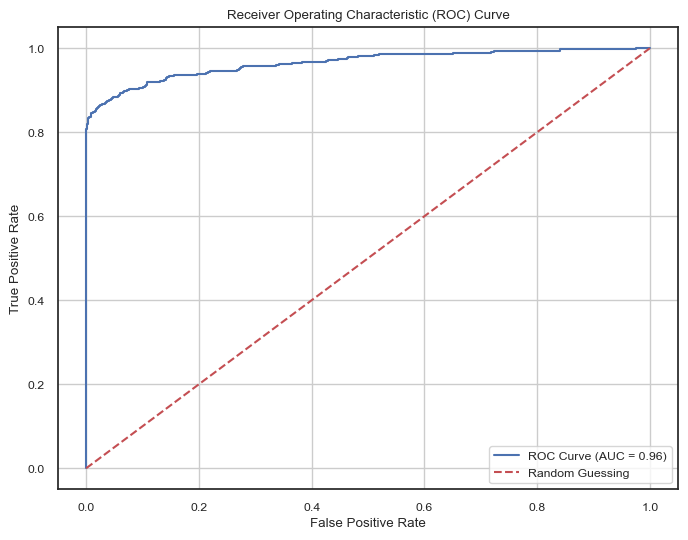

In [108]:
probabilities = best_xgb_model.predict_proba(X_test)

prob_class_1 = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_class_1)
auc_score = roc_auc_score(y_test, prob_class_1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score), color='b')
plt.plot([0, 1], [0, 1], 'k--', color='r', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Get Prediction

In [109]:
df_test_final = pd.read_csv('kaggle_data/playground-series-s3e17/test.csv')


In [110]:
le = LabelEncoder()
df_test_final_trans = df_test_final.copy()
df_test_final_trans['Type'] = le.fit_transform(df_test_final_trans['Type'])
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

scaler = StandardScaler()
df_test_final_trans[numerical_features] = scaler.fit_transform(df_test_final_trans[numerical_features])
df_test_final_trans = df_test_final_trans.drop(['id','Product ID'],axis=1)
df_test_final_trans.columns = [i.replace('[','').replace(']','').replace(' ','_') for i in df_test_final_trans.columns]

In [111]:
df_test_final_trans.head()

,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,TWF,HDF,PWF,OSF,RNF
0,1,1.313830,1.126570,-0.153806,-0.274579,-0.693494,0,0,0,0,0
1,1,0.990824,0.765635,1.375097,-1.356341,-1.366729,0,0,0,0,0
2,1,0.775487,0.332512,0.031949,-0.309854,-0.129855,0,0,0,0,0
3,2,0.129475,-0.244985,-0.296694,0.854217,-1.554608,0,0,0,0,0
4,2,1.906008,1.704068,-0.039496,0.113445,0.151964,0,0,0,0,0


In [112]:
X_train.head()

,Type,Air_temperature_K,Process_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,TWF,HDF,PWF,OSF,RNF
77190,0,-1.268781,-0.751584,2.433893,-1.487691,-1.522852,0,0,0,0,0
10235,0,0.879169,0.475704,-0.478110,-0.052768,1.463166,0,0,0,0,0
9562,0,0.073688,-0.246230,-1.768329,1.805575,-1.147645,0,0,0,0,0
16828,1,-0.570697,0.114737,-0.160961,1.064590,0.009241,0,0,0,0,0
106913,1,0.503278,1.269831,-0.636684,0.641170,-1.601020,0,0,0,0,0


In [113]:
y_pred_final = best_xgb_model.predict(df_test_final_trans)

In [114]:
df_final_binary = pd.DataFrame(columns=['id','Machine failure'])
df_final_binary['id'] = df_test_final['id']
df_final_binary['Machine failure'] = y_pred_final
df_final_binary.to_csv('kaggle_submit/binary_submit.csv',index=False)

In [115]:
df_final_binary

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0
...,...,...
90949,227378,0
90950,227379,0
90951,227380,0
90952,227381,0


In [116]:
y_pred_final_prob = best_xgb_model.predict_proba(df_test_final_trans)

In [117]:
df_final_prob = pd.DataFrame(columns=['id','Machine failure'])
df_final_prob['id'] = df_test_final['id']
df_final_prob['Machine failure'] = y_pred_final_prob[:,1]
df_final_prob.to_csv('kaggle_submit/prob_submit.csv',index=False)

In [118]:
df_final_prob

,id,Machine failure
0,136429,0.001397
1,136430,0.003426
2,136431,0.000788
3,136432,0.001519
4,136433,0.001125
...,...,...
90949,227378,0.001879
90950,227379,0.000912
90951,227380,0.002337
90952,227381,0.000809


## Result

With using XGBoost, I got the final score as 0.9637!

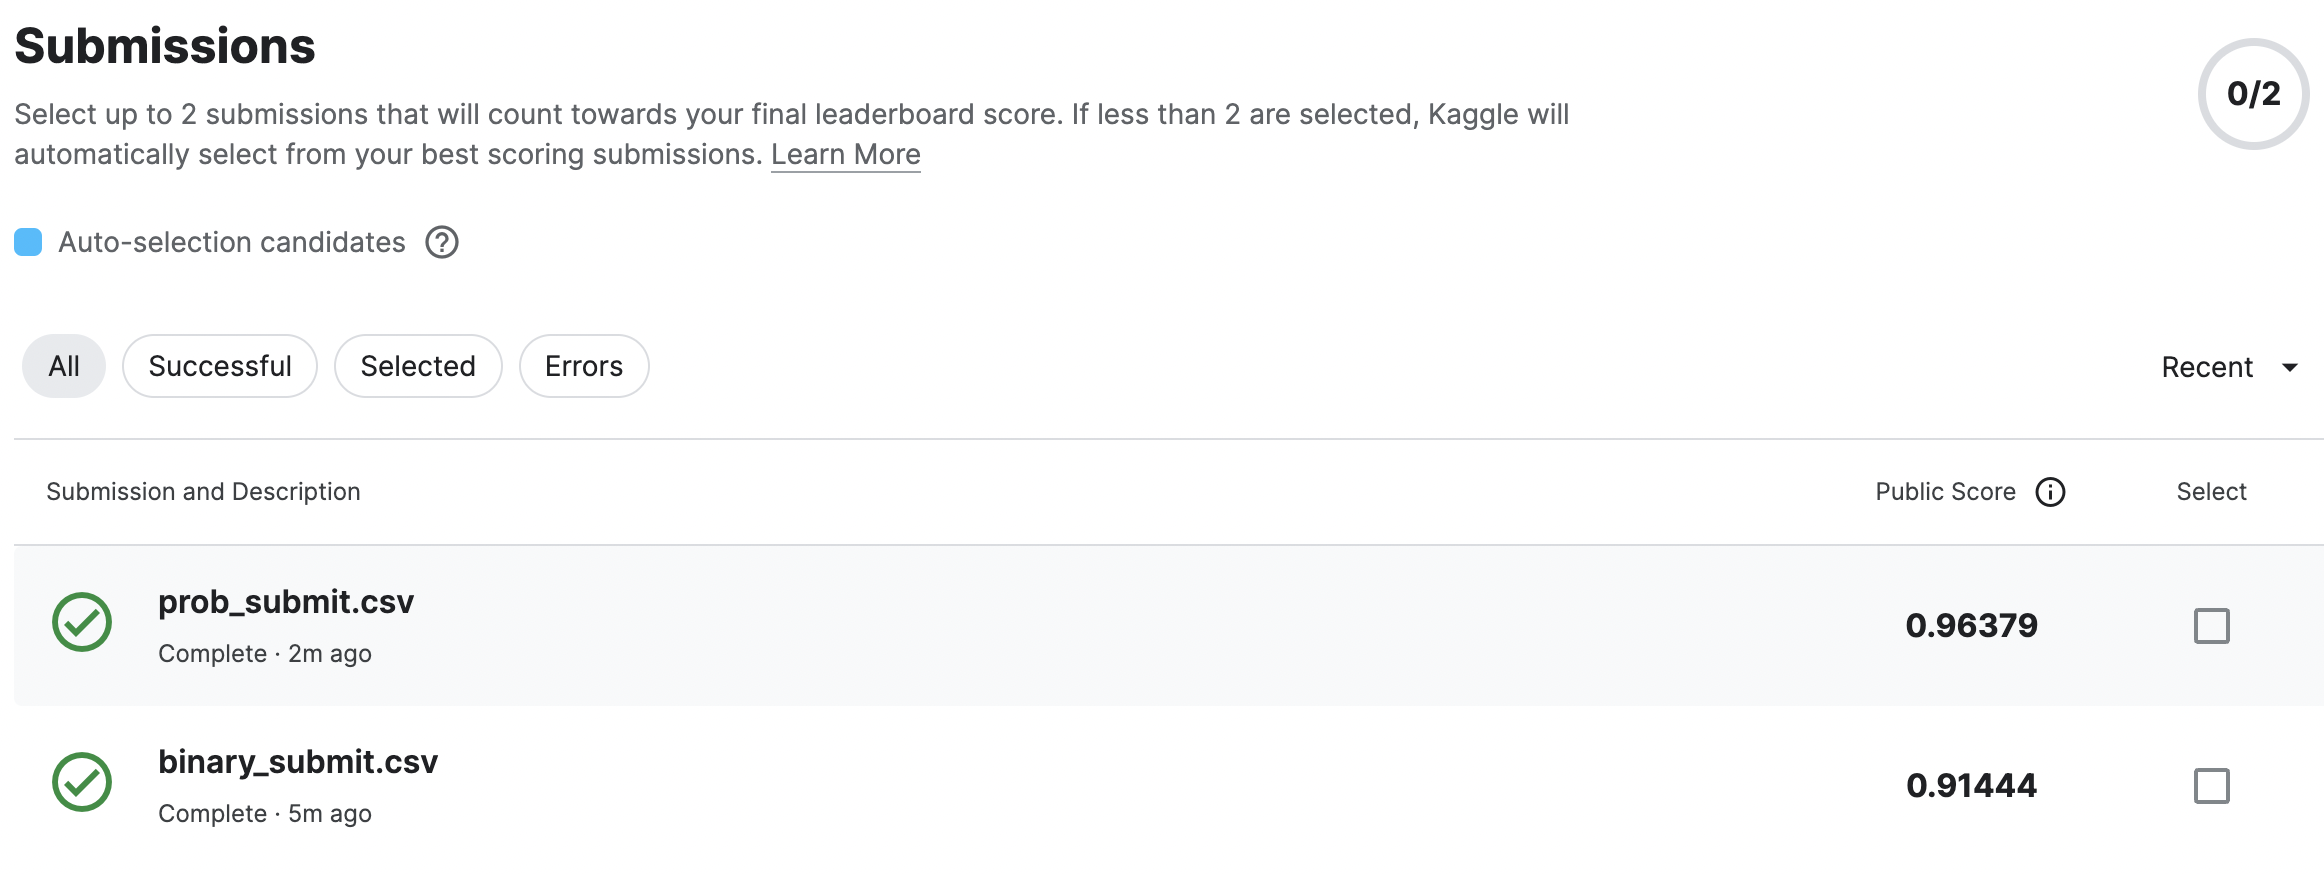

In [119]:
image = Image.open('kaggle_submit/kaggle_submittion.png')
image